In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2
import torchvision.models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

In [2]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'
model_dir = '/opt/ml/weights/3way_resnext/'
labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [4]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        masktoint = {'m' : 0, 'i' : 1, 'n' : 2}
        gendertoint = {'male' : 0, 'female' : 1}
        
        mask = masktoint[features[1][0]]
        age = int(features[0].split('_')[-1])
        gender = gendertoint[features[0].split('_')[1]]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, (mask, gender, age)

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [5]:
from torch.utils.data.dataset import random_split
tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
dataset = TrainDataset(train_dir, transform=tfms)
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.8),int(len(dataset)*0.2)])
# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=False)
val_loader   = DataLoader(dataset=val_dataset, num_workers=4, batch_size=32)

In [6]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

## Model

In [7]:
from efficientnet_pytorch import EfficientNet

class Way3(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnext = torchvision.models.resnext50_32x4d(pretrained=True).to(device)
        self.mask = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1000, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.gender = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1000, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        self.age = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1000, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.best_f1 = 0
        
    def forward(self, x):
        features = self.resnext(x)
        mask = self.mask(features)
        gender = self.gender(features)
        age = self.age(features)
        
        return mask, gender, age
    
model = Way3().to(device)
model.train()

Way3(
  (resnext): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [8]:
import torch.optim as optim
lr = 1.8e-4

w_gender = torch.tensor([1.4, 1.0]).to(device)
w_age = torch.tensor([1.0, 1.2, 4]).to(device)

criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss(w_gender)
age_criterion = nn.CrossEntropyLoss(weight=w_age)
# b_criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85, verbose=True)

Adjusting learning rate of group 0 to 1.8000e-04.


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check(loader, length, model, device):
    model.eval()
    y_true = []
    y_predicted = []

    m_acc = []
    g_acc = []
    a_acc = []
    with torch.no_grad():
        for (inputs, (m, g, a)) in val_loader:
            for mask, gender, age in zip(m, g, a):
                answer = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_true.append(answer)

            inputs = inputs.to(device=device)
            m = m.to(device)
            g = g.to(device)
            a = a.to(device)

            m_pred, g_pred, a_pred = model(inputs)

            m_argmax = m_pred.detach().cpu().numpy().argmax(1)
            g_argmax = g_pred.detach().cpu().numpy().argmax(1)
            a_argmax = a_pred.detach().cpu().numpy().argmax(1)

            m_acc.append(accuracy_score(m_argmax, m.detach().cpu().numpy()))
            g_acc.append(accuracy_score(g_argmax, g.detach().cpu().numpy()))
            a_acc.append(accuracy_score(a_argmax, a.detach().cpu().numpy()))

            for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
                predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_predicted.append(predicted)
    
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)

    s = 0
    for c in range(18):
        s += cm[c][c]
        
    print("< VALIDATION >")
    print("Total Accuracy")
    print(s / length * 100, "%")
    print("-"*73)
    print("Class Accuracy")
    print("Mask   :", np.mean(m_acc)*100, "%")
    print("Gender :", np.mean(g_acc)*100, "%")
    print("Age    :", np.mean(a_acc)*100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        print(row)
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
        torch.save(model.state_dict(), model_dir + 'Aug_{}.pt'.format(model.best_f1))
        print("model saved!")
    print("*"*73)
    print()
    
        
    model.train()

In [10]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_dataset)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, (m, g, a)) in prog_bar:
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        m_pred, g_pred, a_pred = model(inputs)
        
        
        m = m.to(device)
        g = g.to(device)
        a = a.to(device)
        total += m.size(0)
        
        
#         print(g.shape)
#         print(g_pred.shape)
        
#         print(a.shape)
#         print(a_pred.shape)
        
#         print(m.shape)
#         print(m_pred.shape)
        
        m_loss = criterion(m_pred, m)
        g_loss = gender_criterion(g_pred, g)
        a_loss = age_criterion(a_pred, a) # data imbalance
        
        
        loss = (g_loss+a_loss+m_loss)
        loss.backward()
        optimizer.step()
        
#         m_argmax = torch.argmax(m_pred)
        
#         _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total

            print("Loss :", train_loss)
#             print("Accuracy :", train_accuracy)
            
            check(val_loader, len(val_dataset), model, device)
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 506/1012 [01:27<01:26,  5.82it/s]

Loss : 1.7807989181616368
< VALIDATION >
Total Accuracy
73.51851851851852 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.65551181102363 %
Gender : 93.30708661417323 %
Age    : 78.86318897637796 %
-------------------------------------------------------------------------
Confusion Matrix
[533   4   0   8   2   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 56 156  89   0   2   0   0   0   1   0   0   0   0   0   0   0   0   0]
[  3  28 137   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 48   8   0 649  30   1   0   0   0   2   0   0   0   0   0   0   0   0]
[  8  82  10  20 382 138   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   4  12   0  47 183   0   0   1   0   0   1   0   0   0   0   0   0]
[  4   0   0   0   0   0 571  11   2   2   0   0   0   0   0   0   0   0]
[  1   2   0   0   0   0  39 115 152   0   3   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0  17 158   0   0   0   0   0   0   0 

 50%|█████     | 508/1012 [01:51<44:12,  5.26s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:17<00:00,  6.01it/s]

Loss : 1.7279439349419514
< VALIDATION >
Total Accuracy
76.38271604938271 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.42175196850394 %
Gender : 97.07185039370079 %
Age    : 79.12155511811024 %
-------------------------------------------------------------------------
Confusion Matrix
[503  30   1  12   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 177 108   1   4   2   0   2   1   0   0   0   0   0   0   0   0   0]
[  0  22 145   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
[ 17   1   0 684  30   6   0   0   0   0   0   0   0   0   0   0   0   0]
[  2  17   4  30 294 293   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   4   0  23 217   0   0   0   0   0   4   0   0   0   0   0   0]
[  3   0   0   0   0   0 546  31   3   7   0   0   0   0   0   0   0   0]
[  0   0   1   0   0   0  16 179 110   0   3   4   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  17 157   0   0   1   0   0   0   0 

1013it [03:41,  4.57it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.5300e-04.
Epoch : 2



 50%|█████     | 506/1012 [01:26<01:29,  5.63it/s]

Loss : 1.6670664151509602


 50%|█████     | 508/1012 [01:51<43:44,  5.21s/it]  

< VALIDATION >
Total Accuracy
75.24691358024691 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 96.99803149606299 %
Gender : 98.03149606299213 %
Age    : 78.94931102362204 %
-------------------------------------------------------------------------
Confusion Matrix
[475  10   0   4   1   0  58   0   0   0   0   0   0   0   0   0   0   0]
[ 18 118 147   1  13   6   0   0   1   0   0   0   0   0   0   0   0   0]
[  0   8 157   0   2   0   0   0   0   0   0   0   0   0   1   0   0   0]
[ 15   0   0 715   4   0   1   0   0   3   0   0   0   0   0   0   0   0]
[  2   0   0  63 301 271   0   0   0   1   3   0   0   0   0   0   0   0]
[  0   0   0   0  20 224   0   0   0   0   0   4   0   0   0   0   0   0]
[  1   0   0   0   0   0 553  26   3   6   1   0   0   0   0   0   0   0]
[  0  10   9   0   2   0  21 114 145   0   8   2   0   1   1   0   0   0]
[  0   1   6   0   0   0   0   9 158   0   0   1   0   0   0   0   0   0]
[  0   0   0   4 

100%|█████████▉| 1011/1012 [03:16<00:00,  5.99it/s]

Loss : 1.6513192611249539
< VALIDATION >
Total Accuracy
83.33333333333334 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.56938976377953 %
Gender : 97.14566929133859 %
Age    : 86.0236220472441 %
-------------------------------------------------------------------------
Confusion Matrix
[510   0   0  37   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 47 143  65  10  29   8   0   2   0   0   0   0   0   0   0   0   0   0]
[  2  23 134   0   2   7   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 725   2   0   0   0   0   7   0   0   0   0   0   0   0   0]
[  0   1   0 101 394 142   0   0   0   1   2   0   0   0   0   0   0   0]
[  0   0   0   0  40 206   0   0   0   0   0   2   0   0   0   0   0   0]
[  7   0   0   0   0   0 550   2   0  30   1   0   0   0   0   0   0   0]
[  0   0   0   0   2   0  37 173  67   7  24   3   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  26 144   0   3   2   0   0   0   0  

1013it [03:41,  4.58it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.3005e-04.
Epoch : 3



 50%|█████     | 506/1012 [01:26<01:24,  5.97it/s]

Loss : 1.6082854463739038


 50%|█████     | 508/1012 [01:50<43:13,  5.15s/it]  

< VALIDATION >
Total Accuracy
83.2962962962963 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.61860236220473 %
Gender : 98.84350393700787 %
Age    : 84.53494094488188 %
-------------------------------------------------------------------------
Confusion Matrix
[527  12   0   8   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 11 192  97   0   2   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0  16 149   0   0   2   1   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 702  26   0   0   0   0   4   0   0   0   0   0   0   0   0]
[  0   1   0  19 440 176   0   0   0   0   4   1   0   0   0   0   0   0]
[  0   1   1   0  32 210   0   0   0   0   1   3   0   0   0   0   0   0]
[  4   0   0   0   0   0 569   8   1   8   0   0   0   0   0   0   0   0]
[  0   4   1   0   0   0  21 161 123   0   1   2   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   8 164   0   1   2   0   0   0   0   0   0]
[  0   0   0   2  

100%|█████████▉| 1011/1012 [03:15<00:00,  5.89it/s]

Loss : 1.6013101722176366
< VALIDATION >
Total Accuracy
85.33333333333334 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.37253937007874 %
Gender : 98.4005905511811 %
Age    : 87.04478346456693 %
-------------------------------------------------------------------------
Confusion Matrix
[535   8   0   4   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 12 170 117   0   1   4   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  13 154   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
[ 13   5   0 659  60   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   4   1   6 497 132   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  34 213   0   0   0   0   0   1   0   0   0   0   0   0]
[  5   0   0   0   0   0 576   6   0   3   0   0   0   0   0   0   0   0]
[  0   4   1   0   0   1  19 167 112   0   4   5   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 169   0   0   0   0   0   0   0  

1013it [03:40,  4.59it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.1054e-04.
Epoch : 4



 50%|█████     | 506/1012 [01:26<01:26,  5.88it/s]

Loss : 1.5717693985801713
< VALIDATION >
Total Accuracy
87.95061728395062 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.58169291338582 %
Gender : 99.02805118110236 %
Age    : 89.1240157480315 %
-------------------------------------------------------------------------
Confusion Matrix
[539   1   1   6   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 21 236  43   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  1  41 125   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10   1   0 696  31   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   1   1  17 528  93   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  46 201   0   0   0   0   1   0   0   0   0   0   0   0]
[  4   0   0   0   0   0 567   4   2  13   0   0   0   0   0   0   0   0]
[  0   2   1   0   0   0  16 246  45   2   1   0   0   0   0   0   0   0]
[  0   0   3   0   0   0   0  29 143   0   0   0   0   0   0   0  

 50%|█████     | 508/1012 [01:50<43:57,  5.23s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:17<00:00,  5.98it/s]

Loss : 1.5709770577462765


1013it [03:41,  4.58it/s]                          

< VALIDATION >
Total Accuracy
86.97530864197532 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.71702755905511 %
Gender : 98.20374015748031 %
Age    : 88.68110236220473 %
-------------------------------------------------------------------------
Confusion Matrix
[518  23   1   4   1   0   0   0   0   0   0   0   1   0   0   0   0   0]
[  9 203  59   0  28   4   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  23 131   0   6   8   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   1   0 704  26   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0  22 494 123   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   0   0  30 214   0   0   0   0   1   3   0   0   0   0   0   0]
[  6   0   0   0   0   0 561  16   0   6   1   0   0   0   0   0   0   0]
[  0   0   1   0   0   0  18 214  44   0  36   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  20 143   0   5   7   0   0   0   0   0   0]
[  0   0   0   1 


 50%|█████     | 506/1012 [01:27<01:25,  5.95it/s]

Loss : 1.5480179180054976
< VALIDATION >
Total Accuracy
89.32098765432099 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.50787401574803 %
Gender : 99.26181102362204 %
Age    : 90.28051181102363 %
-------------------------------------------------------------------------
Confusion Matrix
[542   1   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 31 211  52   0   9   0   0   0   1   0   0   0   0   0   0   0   0   0]
[  0  23 144   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   1   0 696  32   1   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0  12 589  38   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   0   0  62 183   0   0   0   0   0   3   0   0   0   0   0   0]
[  4   0   0   0   0   0 583   1   0   2   0   0   0   0   0   0   0   0]
[  3   2   3   0   0   0  39 186  75   1   4   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   9 166   0   0   0   0   0   0   0 

 50%|█████     | 508/1012 [01:51<43:09,  5.14s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:16<00:00,  5.95it/s]

Loss : 1.5465196872888347


1013it [03:40,  4.59it/s]                          

< VALIDATION >
Total Accuracy
88.67901234567901 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.75393700787401 %
Gender : 99.05265748031496 %
Age    : 89.73917322834646 %
-------------------------------------------------------------------------
Confusion Matrix
[539   2   1   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 11 210  79   1   2   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  14 152   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10   0   0 717   9   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   2   0  36 521  79   0   0   0   0   3   0   0   0   0   0   0   0]
[  0   0   0   0  41 205   0   0   0   0   0   2   0   0   0   0   0   0]
[  5   0   0   0   0   0 564  13   2   4   2   0   0   0   0   0   0   0]
[  0   2   0   0   0   0  13 216  81   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  11 162   0   0   2   0   0   0   0   0   0]
[  0   0   0   2 


 50%|█████     | 506/1012 [01:27<01:25,  5.89it/s]

Loss : 1.5214844126202887
< VALIDATION >
Total Accuracy
88.71604938271605 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.37253937007874 %
Age    : 89.39468503937007 %
-------------------------------------------------------------------------
Confusion Matrix
[534   7   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 227  65   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  10 157   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 678  50   3   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   9 499 131   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   1   0  17 228   0   0   0   0   0   2   0   0   0   0   0   0]
[  5   0   0   0   0   0 576   3   1   4   0   1   0   0   0   0   0   0]
[  0   1   0   0   0   0  13 216  79   0   3   1   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   4 166   0   1   4   0   0   0   0 

 50%|█████     | 508/1012 [01:52<45:00,  5.36s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:17<00:00,  5.89it/s]

Loss : 1.5185616987024841
< VALIDATION >
Total Accuracy
91.77777777777779 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.76624015748031 %
Gender : 99.13877952755905 %
Age    : 92.61811023622047 %
-------------------------------------------------------------------------
Confusion Matrix
[540   2   2   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 13 258  31   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  26 142   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 15   1   0 714   7   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   4   1  17 517 100   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   0  12 233   0   0   0   0   0   2   0   0   0   0   0   0]
[  6   0   0   0   0   0 581   1   0   2   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0  15 264  31   0   0   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0  16 158   0   0   1   0   0   0   0 

1013it [03:42,  4.56it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 6.7887e-05.
Epoch : 7



 50%|█████     | 506/1012 [01:27<01:24,  6.00it/s]

Loss : 1.4966931418319191


 50%|█████     | 508/1012 [01:51<43:36,  5.19s/it]  

< VALIDATION >
Total Accuracy
91.8641975308642 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.85236220472441 %
Gender : 99.38484251968504 %
Age    : 92.49507874015748 %
-------------------------------------------------------------------------
Confusion Matrix
[538   1   1   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 15 218  69   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  10 158   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 714  17   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   3   1  12 573  52   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   1   0  26 221   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0   0   0   0 577   0   0   9   0   0   0   0   0   0   0   0]
[  0   0   1   0   0   0  25 226  59   1   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   9 166   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  

100%|█████████▉| 1011/1012 [03:17<00:00,  5.88it/s]

Loss : 1.5009257915934084
< VALIDATION >
Total Accuracy
92.64197530864197 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.65551181102363 %
Gender : 99.29872047244095 %
Age    : 93.59005905511812 %
-------------------------------------------------------------------------
Confusion Matrix
[533   4   3   6   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
[ 11 262  29   1   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  18 149   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10   0   0 720   4   0   0   0   0   4   0   0   0   0   0   0   0   0]
[  3   3   0  40 562  29   0   0   0   0   4   0   0   0   0   0   0   0]
[  0   0   1   0  41 202   0   0   0   0   0   4   0   0   0   0   0   0]
[  2   0   0   0   0   0 577   7   2   2   0   0   0   0   0   0   0   0]
[  0   3   0   0   0   0  10 257  40   0   2   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0  10 165   0   0   0   0   0   0   0 

1013it [03:42,  4.55it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 5.7704e-05.
Epoch : 8



 50%|█████     | 506/1012 [01:27<01:31,  5.56it/s]

Loss : 1.4937290571615305
< VALIDATION >
Total Accuracy
93.61728395061728 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.82775590551181 %
Gender : 99.52017716535433 %
Age    : 94.21751968503938 %
-------------------------------------------------------------------------
Confusion Matrix
[542   1   0   4   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 13 253  33   1   3   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  24 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9   0   0 722   4   0   0   0   0   3   0   0   0   0   0   0   0   0]
[  1   0   0  26 566  46   0   0   0   1   1   0   0   0   0   0   0   0]
[  0   0   0   0  21 225   0   0   0   0   0   2   0   0   0   0   0   0]
[  1   0   0   0   0   0 586   1   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  14 259  39   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  14 161   0   0   0   0   0   0   0 

 50%|█████     | 508/1012 [01:52<44:31,  5.30s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:18<00:00,  5.75it/s]

Loss : 1.4906832863219641
< VALIDATION >
Total Accuracy
93.82716049382715 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.45866141732283 %
Age    : 94.45127952755905 %
-------------------------------------------------------------------------
Confusion Matrix
[539   4   0   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 251  40   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  14 153   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 701  28   3   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2   0   4 579  56   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  10 238   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 580   4   0   5   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  13 250  48   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  10 165   0   0   0   0   0   0   0 

1013it [03:43,  4.54it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 4.9048e-05.
Epoch : 9



 50%|█████     | 506/1012 [01:27<01:27,  5.80it/s]

Loss : 1.4720683245969242
< VALIDATION >
Total Accuracy
95.43209876543209 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.63090551181102 %
Age    : 95.90305118110236 %
-------------------------------------------------------------------------
Confusion Matrix
[543   1   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 262  28   0   2   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   9 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 722  11   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   2   0  15 595  29   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  18 228   0   0   0   0   0   2   0   0   0   0   0   0]
[  2   0   0   0   0   0 583   3   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  10 273  29   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 169   0   0   0   0   0   0   0 

 50%|█████     | 508/1012 [01:52<44:23,  5.28s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:18<00:00,  5.88it/s]

Loss : 1.4762323411557043


1013it [03:42,  4.54it/s]                          

< VALIDATION >
Total Accuracy
95.1358024691358 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9015748031496 %
Gender : 99.50787401574803 %
Age    : 95.74311023622047 %
-------------------------------------------------------------------------
Confusion Matrix
[539   5   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 255  37   0   1   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   6 161   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  8   0   0 721   7   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   6 599  35   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   1   0  17 230   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 582   4   0   3   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  10 270  31   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 169   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   


 50%|█████     | 506/1012 [01:27<01:27,  5.78it/s]

Loss : 1.461610635591917


 50%|█████     | 508/1012 [01:52<44:21,  5.28s/it]  

< VALIDATION >
Total Accuracy
95.22222222222221 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.86466535433071 %
Gender : 99.64320866141733 %
Age    : 95.71850393700787 %
-------------------------------------------------------------------------
Confusion Matrix
[543   1   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 256  36   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   9 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 719  12   0   0   0   0   3   0   0   0   0   0   0   0   0]
[  0   2   0   9 606  24   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  15 231   0   0   0   0   0   2   0   0   0   0   0   0]
[  1   0   0   0   0   0 585   0   1   3   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  11 248  52   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 169   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 

100%|█████████▉| 1011/1012 [03:18<00:00,  5.88it/s]

Loss : 1.4612148174419706
< VALIDATION >
Total Accuracy
96.06172839506173 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.70472440944881 %
Age    : 96.48129921259843 %
-------------------------------------------------------------------------
Confusion Matrix
[540   4   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 268  24   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  22 146   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 723   6   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0   7 624  10   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  23 224   0   0   0   0   0   1   0   0   0   0   0   0]
[  3   0   0   0   0   0 585   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  13 269  30   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   8 167   0   0   0   0   0   0   0 

1013it [03:43,  4.54it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 3.5437e-05.
Epoch : 11



 50%|█████     | 506/1012 [01:27<01:25,  5.90it/s]

Loss : 1.4553760229012904
< VALIDATION >
Total Accuracy
96.1604938271605 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.55708661417323 %
Age    : 96.72736220472441 %
-------------------------------------------------------------------------
Confusion Matrix
[541   3   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 271  21   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  11 157   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8   0   0 715  15   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   5 604  32   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   9 238   0   0   0   0   0   1   0   0   0   0   0   0]
[  4   0   0   0   0   0 584   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  13 277  21   0   0   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0   7 168   0   0   0   0   0   0   0  

 50%|█████     | 508/1012 [01:52<44:05,  5.25s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:19<00:00,  5.89it/s]

Loss : 1.4571362641960264


1013it [03:43,  4.53it/s]                          

< VALIDATION >
Total Accuracy
96.03703703703704 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.60629921259843 %
Age    : 96.44438976377953 %
-------------------------------------------------------------------------
Confusion Matrix
[543   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 13 268  18   0   2   1   0   2   0   0   0   0   0   0   0   0   0   0]
[  0  13 155   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 727   6   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   2   0  10 604  25   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   9 238   0   0   0   0   0   1   0   0   0   0   0   0]
[  1   0   0   0   0   0 585   1   0   3   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  11 279  22   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   7 167   0   0   1   0   0   0   0   0   0]
[  0   0   0   0  


 50%|█████     | 506/1012 [01:27<01:24,  5.98it/s]

Loss : 1.45284108908689
< VALIDATION >
Total Accuracy
96.90123456790124 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.84005905511812 %
Gender : 99.65551181102363 %
Age    : 97.30561023622047 %
-------------------------------------------------------------------------
Confusion Matrix
[543   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 272  20   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   5 163   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 725   6   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   3   1   5 620  12   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  13 234   0   0   0   0   0   1   0   0   0   0   0   0]
[  1   0   0   0   0   0 587   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  11 278  22   0   0   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0   4 171   0   0   0   0   0   0   0   

 50%|█████     | 508/1012 [01:52<44:32,  5.30s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:19<00:00,  5.80it/s]

Loss : 1.4507834493171556
< VALIDATION >
Total Accuracy
96.98765432098766 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.68011811023622 %
Age    : 97.42864173228347 %
-------------------------------------------------------------------------
Confusion Matrix
[543   1   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 11 273  19   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   7 161   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 728   4   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   8 616  16   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   9 239   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0   0   0   0 583   1   1   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  11 280  20   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 172   0   0   0   0   0   0   0  

1013it [03:43,  4.53it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 2.5604e-05.
Epoch : 13



 50%|█████     | 506/1012 [01:27<01:26,  5.83it/s]

Loss : 1.444366369962222


 50%|█████     | 508/1012 [01:52<44:43,  5.32s/it]  

< VALIDATION >
Total Accuracy
96.96296296296296 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.86466535433071 %
Gender : 99.74163385826772 %
Age    : 97.34251968503938 %
-------------------------------------------------------------------------
Confusion Matrix
[544   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 12 270  20   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   5 163   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 721  13   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   4 609  28   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   5 243   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0   0   0   0 585   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  12 275  24   0   0   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0   3 172   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 

100%|█████████▉| 1011/1012 [03:18<00:00,  5.97it/s]

Loss : 1.4434187339228604
< VALIDATION >
Total Accuracy
96.93827160493828 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.71702755905511 %
Age    : 97.41633858267717 %
-------------------------------------------------------------------------
Confusion Matrix
[544   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 273  20   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   2 166   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 726   3   0   0   0   0   5   0   0   0   0   0   0   0   0]
[  0   0   0  10 612  15   0   0   0   0   4   0   0   0   0   0   0   0]
[  0   0   0   0   5 241   0   0   0   0   0   2   0   0   0   0   0   0]
[  1   0   0   0   0   0 587   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  10 278  23   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 173   0   0   0   0   0   0   0 

1013it [03:42,  4.55it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 2.1763e-05.
Epoch : 14



 50%|█████     | 506/1012 [01:26<01:26,  5.84it/s]

Loss : 1.4420152820308767
< VALIDATION >
Total Accuracy
97.1358024691358 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.74163385826772 %
Gender : 99.68011811023622 %
Age    : 97.71161417322834 %
-------------------------------------------------------------------------
Confusion Matrix
[542   0   0   4   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
[  8 268  26   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   6 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 723   5   0   0   0   0   5   0   0   0   0   0   0   0   0]
[  0   0   0   5 604  24   0   0   0   0   8   0   0   0   0   0   0   0]
[  0   0   1   0   6 239   0   0   0   0   0   2   0   0   0   0   0   0]
[  1   0   0   0   0   0 584   2   0   2   1   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   9 286  16   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 172   0   0   0   0   0   0   0  

 50%|█████     | 508/1012 [01:51<43:58,  5.23s/it]  

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [03:16<00:00,  5.96it/s]

Loss : 1.4408029317855835
< VALIDATION >
Total Accuracy
97.38271604938271 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.84005905511812 %
Gender : 99.70472440944881 %
Age    : 97.83464566929135 %
-------------------------------------------------------------------------
Confusion Matrix
[543   0   0   4   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 10 279  12   0   1   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   7 161   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 728   3   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0   6 609  25   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   5 240   0   0   0   0   0   3   0   0   0   0   0   0]
[  1   0   0   0   0   0 587   0   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  11 287  14   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   8 167   0   0   0   0   0   0   0 

1013it [03:41,  4.58it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.8499e-05.
Epoch : 15



 50%|█████     | 506/1012 [01:26<01:25,  5.90it/s]

Loss : 1.438280212808643


 50%|█████     | 508/1012 [01:50<42:56,  5.11s/it]  

< VALIDATION >
Total Accuracy
96.74074074074073 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.61860236220473 %
Age    : 97.24409448818898 %
-------------------------------------------------------------------------
Confusion Matrix
[544   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 272  21   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   7 161   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 721  10   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   3   0   3 598  37   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   3 244   0   0   0   0   0   1   0   0   0   0   0   0]
[  3   0   0   0   0   0 585   0   0   2   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0   9 278  22   0   1   0   0   1   0   0   0   0]
[  0   0   0   0   0   0   0   3 172   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 

100%|█████████▉| 1011/1012 [03:16<00:00,  5.98it/s]

Loss : 1.437180322385117
< VALIDATION >
Total Accuracy
97.91358024691358 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9384842519685 %
Gender : 99.66781496062993 %
Age    : 98.30216535433071 %
-------------------------------------------------------------------------
Confusion Matrix
[544   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8 281  14   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   6 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 728   3   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   9 621  10   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   1   0   5 242   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   0   0   0   0   0 585   1   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  10 286  16   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 172   0   0   0   0   0   0   0   

1013it [03:41,  4.58it/s]                          

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.5724e-05.
Finish


## Testing

In [11]:
model.load_state_dict(torch.load('/opt/ml/weights/3way_resnext/Aug_{}.pt'.format(model.best_f1)))
# model.load_state_dict(torch.load('/opt/ml/weights/3way/Aug_0.9841404744270768.pt'.format(model.best_f1)))

FileNotFoundError: [Errno 2] No such file or directory: '/opt/ml/weights/3way_resnext/Aug_0.9725228044921087.pt'

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms_test)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        m_pred, g_pred, a_pred = model(images)
#         print(images.shape)
#         print(m_pred.shape)
        m_argmax = m_pred.detach().cpu().numpy().argmax(1)
        g_argmax = g_pred.detach().cpu().numpy().argmax(1)
        a_argmax = a_pred.detach().cpu().numpy().argmax(1)
        
        for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
            predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
            all_predictions.append(predicted)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

Incorrect : 97.96199202537537 %
Female : 99.99891519546509 %
~ 30 : 99.99921321868896 %


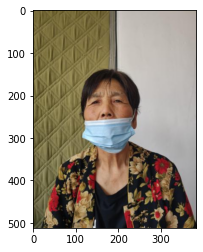

In [18]:
idx = 100
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
m_pred, g_pred, a_pred = model(image)

m_argmax = m_pred.detach().cpu().numpy().argmax(1)
g_argmax = g_pred.detach().cpu().numpy().argmax(1)
a_argmax = a_pred.detach().cpu().numpy().argmax(1)

#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}
#
print(masklabel[m_argmax[0]]+ " :", (m_pred[0][m_argmax].item())*100, '%')
print(genderlabel[g_argmax[0]]+ " :", (g_pred[0][g_argmax].item())*100, '%')
print(agelabel[a_argmax[0]]+ " :", (a_pred[0][a_argmax].item())*100, '%')
